In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import dtw
import improved_dtw

from data_processing import DataIterator
from models import Autoregression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data from Social Competition Task
[Download dataset](http://neurotycho.brain.riken.jp/download/base/20100803S1_Social+Competition_K2_Toru+Yanagawa_csv_ECoG128-Eye9-Motion22-Event3.zip)

In [2]:
data = pd.read_csv('../data/Eye-Motion/ECoG.csv', header=0, nrows=120000)

## Формат данных
Данные представляют собой зависимость потенциалов в 128 точках мозга обезъяны от времени.   
Показатели снимаются каждую миллисекунду.  

Всего - 3697432 измерений

In [3]:
data_sample = data.loc[100000:100700, :"ECoG_ch6"]

In [4]:
data_sample.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
100000,100.000,51,111,-101,107,-18,118
100001,100.001,63,118,-101,115,13,166
100002,100.002,62,137,-87,143,21,167
100003,100.003,65,146,-61,124,16,201
100004,100.004,94,167,-57,109,89,268


## Визуализация данных
Данные взяты из середины выборки

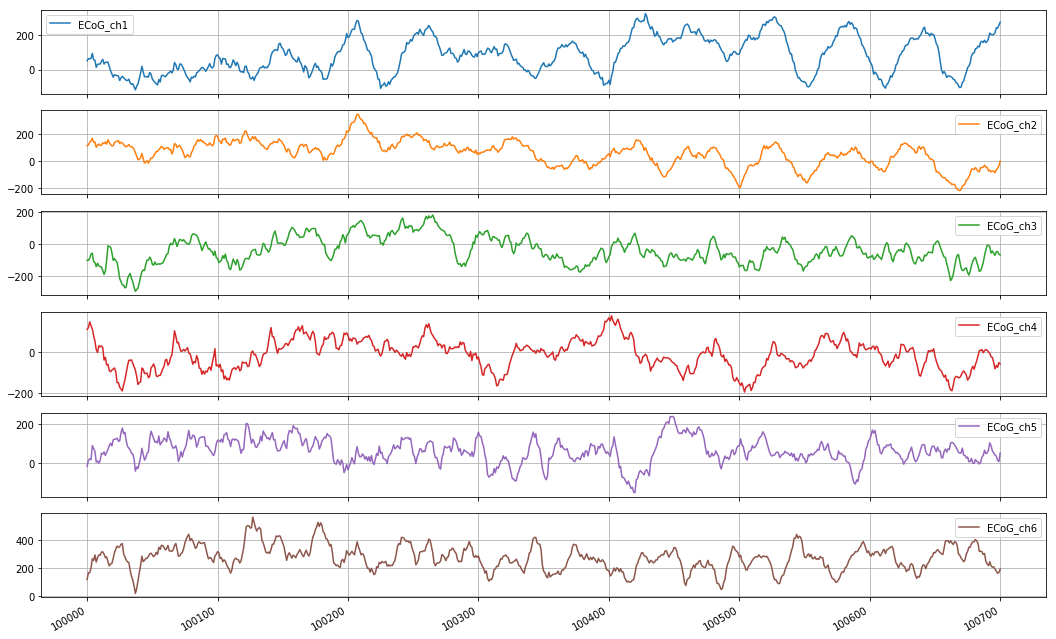

In [5]:
%matplotlib inline
data_sample.loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 12), grid=True);

## Проведем серию усреднений, чтобы посмотреть на тенденции измерения потенциалов
### Небольшое усреднение по трем, рядом лежащим, точкам

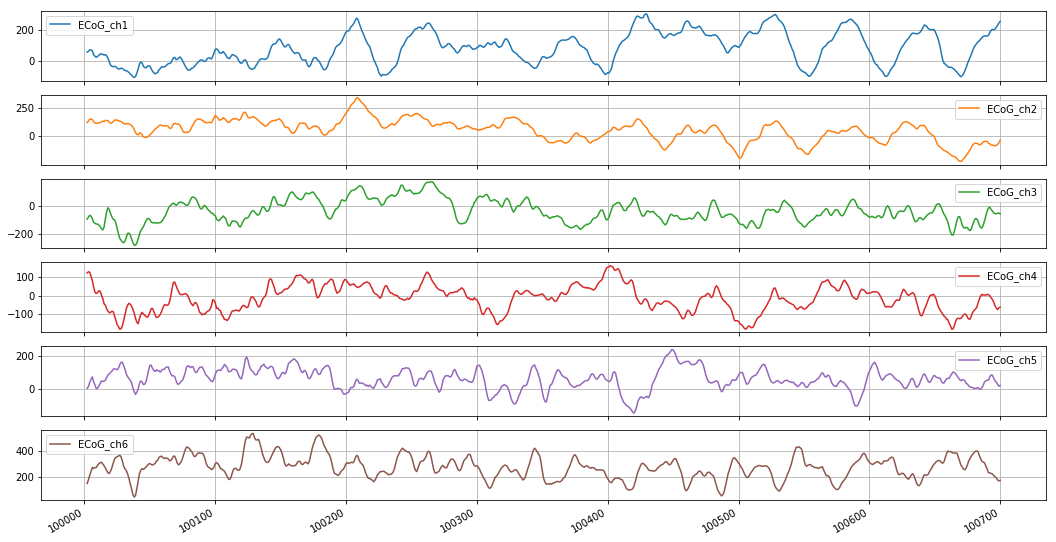

In [6]:
%matplotlib inline
data_sample.rolling(window=3).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Усреднение по 20 точкам

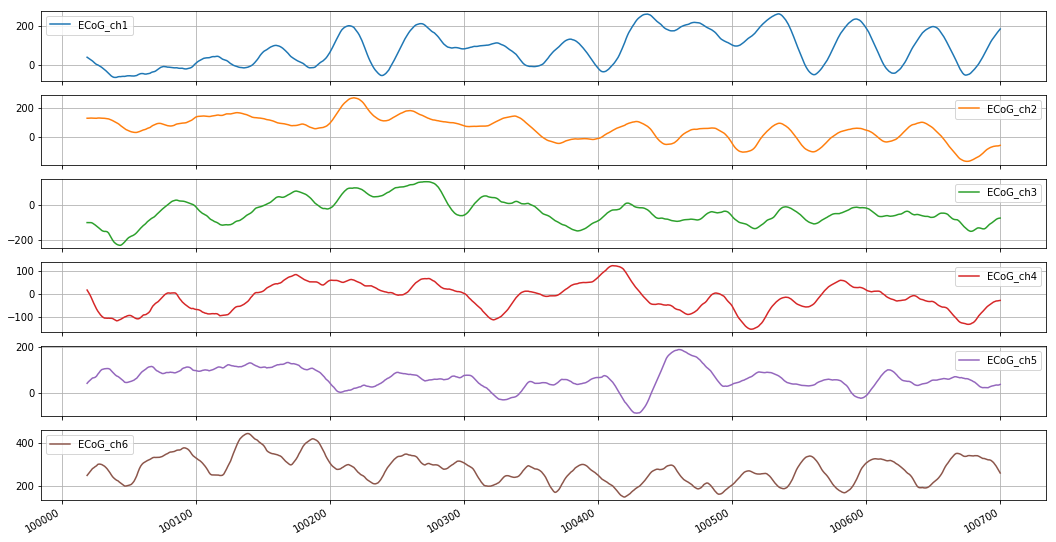

In [7]:
%matplotlib inline
data_sample.rolling(window=20).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Посмотрим на маленький отрезок данных

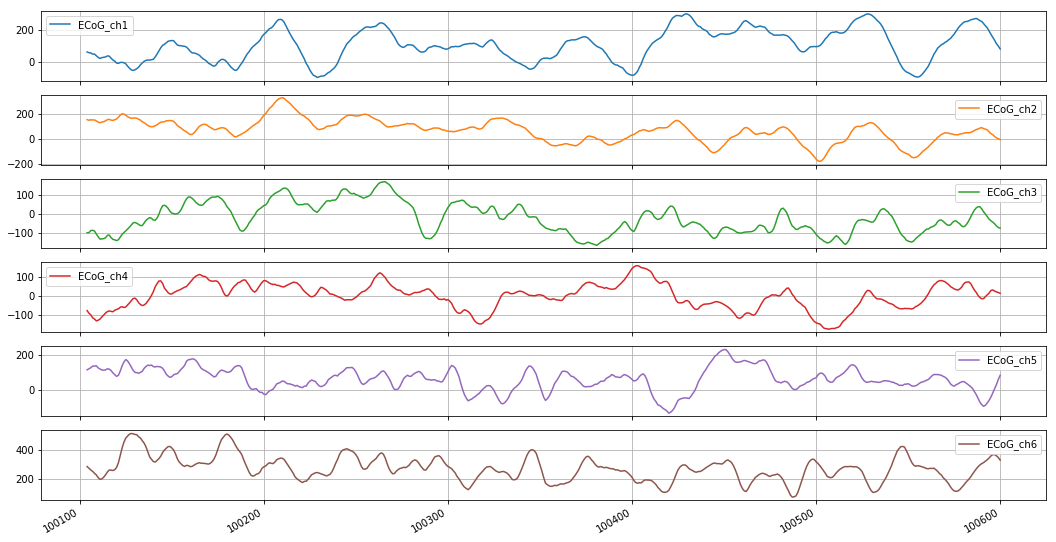

In [8]:
%matplotlib inline
data_sample.loc[100100:100600, "ECoG_ch1":].rolling(window=5).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Для большего количества измерений

In [9]:
data_sample = data.loc[:100000, :"ECoG_ch6"]

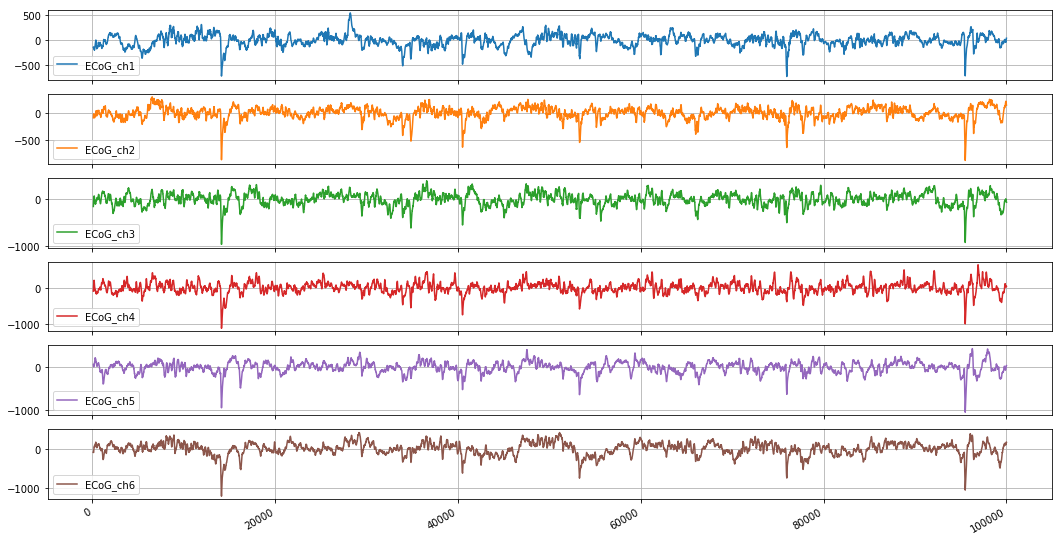

In [10]:
%matplotlib inline
data_sample.rolling(window=100).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Предположение
Можно попробовать два варианта разбиения временных рядом по 100 и по 300 точек.  
Так как в среднем, за этот период ряд претерпевает изменение значений в обе стороны.

In [11]:
#  Итератор для данных, ряды переманны
element_length = 100
data_iter = DataIterator(data_sample, element_length)

In [12]:
item = next(data_iter)

In [13]:
item.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
11600,11.600,-134,-133,195,311,15,20
11601,11.601,-133,-138,163,288,43,33
11602,11.602,-167,-208,76,212,21,41
11603,11.603,-217,-283,-33,129,-81,-31
11604,11.604,-125,-165,82,190,-81,-107


## Эксперимент с DTW для первого измерения

In [14]:
x = next(data_iter).loc[:, "ECoG_ch1"]
y = next(data_iter).loc[:, "ECoG_ch1"]

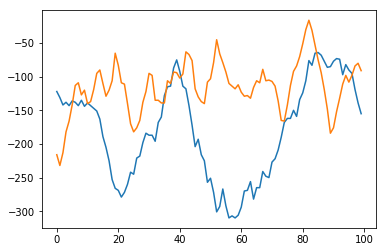

In [15]:
%matplotlib inline
time = np.linspace(0, element_length - 1, element_length)
plt.plot(time, x)
plt.plot(time, y)

In [16]:
def one_dimension_dtw(x, y):
    return dtw.dtw(x.values.reshape(-1, 1), y.values.reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [17]:
dist, cost, acc, path = one_dimension_dtw(x, y)

Distance: 26.275


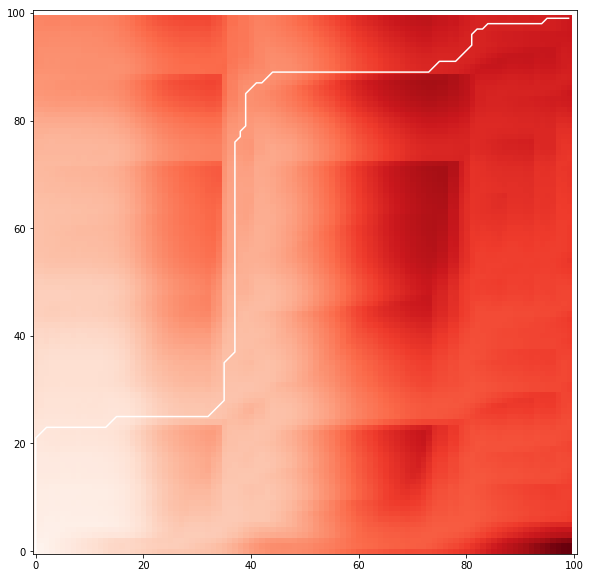

In [18]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

# Эксперимент с авторегрессионной моделью

In [19]:
import torch

In [20]:
window_size = 10
ar = Autoregression(item.loc[:, :"ECoG_ch5"], window_size)

In [21]:
ar.fit(10)

Loss: 151976.453
Loss: 17246.438
Loss: 16924.375
Loss: 16740.174
Loss: 16602.312
Loss: 16493.160
Loss: 16405.119
Loss: 16333.461
Loss: 16274.790
Loss: 16226.466
Loss: 16186.458
Loss: 16153.175
Loss: 16125.354
Loss: 16101.993
Loss: 16082.293


In [22]:
predicted = ar.predicted_series()
x = ar.data.loc[:, "ECoG_ch1" : "ECoG_ch5"].values

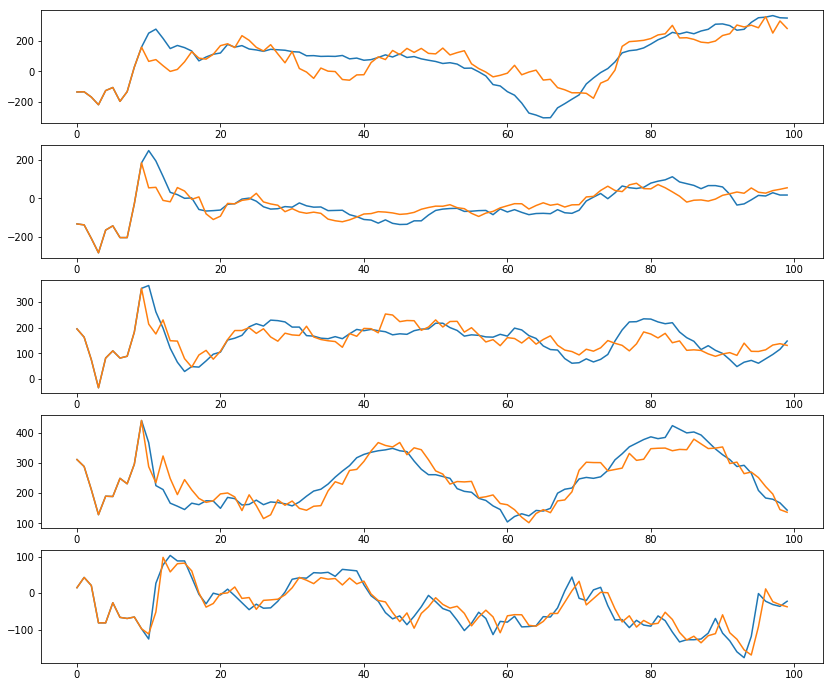

In [23]:
plt.figure(figsize=(14, 12))
time = np.linspace(0, element_length - 1, element_length)

for (i, pred) in enumerate(predicted):
    
    plt.subplot(len(predicted), 1, i+1)
    plt.plot(time, x[:,i])
    plt.plot(time, pred)

plt.show()

# Эксперименты с многомерным DTW

In [24]:
from dtw import dtw as dtw_custom

In [25]:
x = next(data_iter)
y = next(data_iter)

In [26]:
x = x.loc[:, "ECoG_ch1":"ECoG_ch3"].values
y = y.loc[:, "ECoG_ch1":"ECoG_ch3"].values

Заметим, что достаточно передать функцию, которая определяет расстояния между векторами

In [27]:
distance = lambda x, y: np.linalg.norm(x - y)

In [28]:
%time
dist, cost, acc, path = dtw_custom(x, y, distance)

Wall time: 0 ns


Distance: 158.349


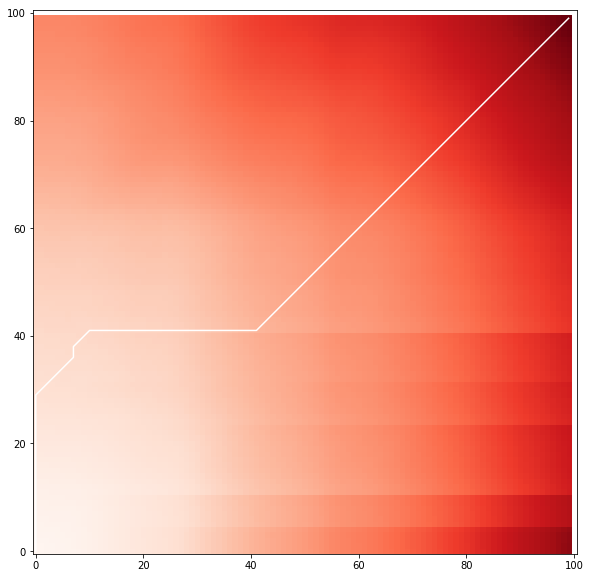

In [29]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

## Различные нормы

### Cosine

In [2]:
from scipy.spatial import distance

In [31]:
%time
dist, cost, acc, path = dtw.dtw_ln(x, y, distance.cosine)

Wall time: 0 ns


Distance: 0.273


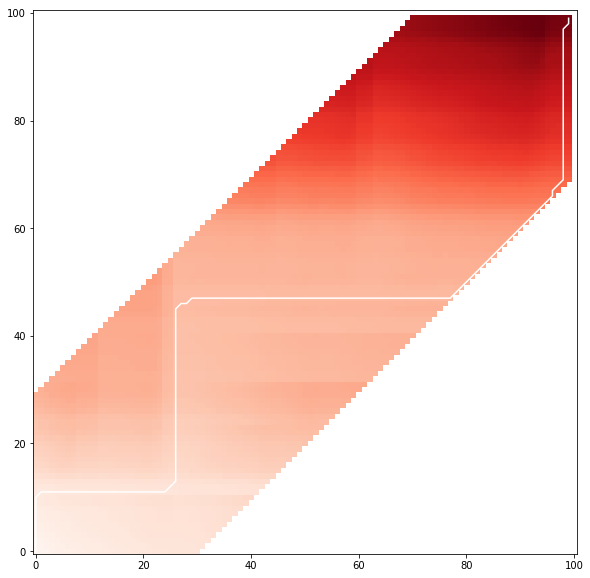

In [32]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

## Иерархическая кластеризация

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [34]:
shape = next(data_iter).loc[:, "ECoG_ch1":"ECoG_ch3"].values.shape

In [35]:
dtw_dist = lambda x, y: (dtw.dtw_ln(x.reshape(shape), y.reshape(shape), distance.chebyshev)[0])
next_prepared = lambda it: next(it).loc[:, "ECoG_ch1":"ECoG_ch3"].values.reshape(1, -1)[0]

In [36]:
X = [next(data_iter) for i in range(40)]
X_reshaped = np.array([x.loc[:, "ECoG_ch1":"ECoG_ch3"].values.reshape(1, -1)[0] for x in X])

In [37]:
%time Z = linkage(X_reshaped, metric=dtw_dist)

Wall time: 1min 15s


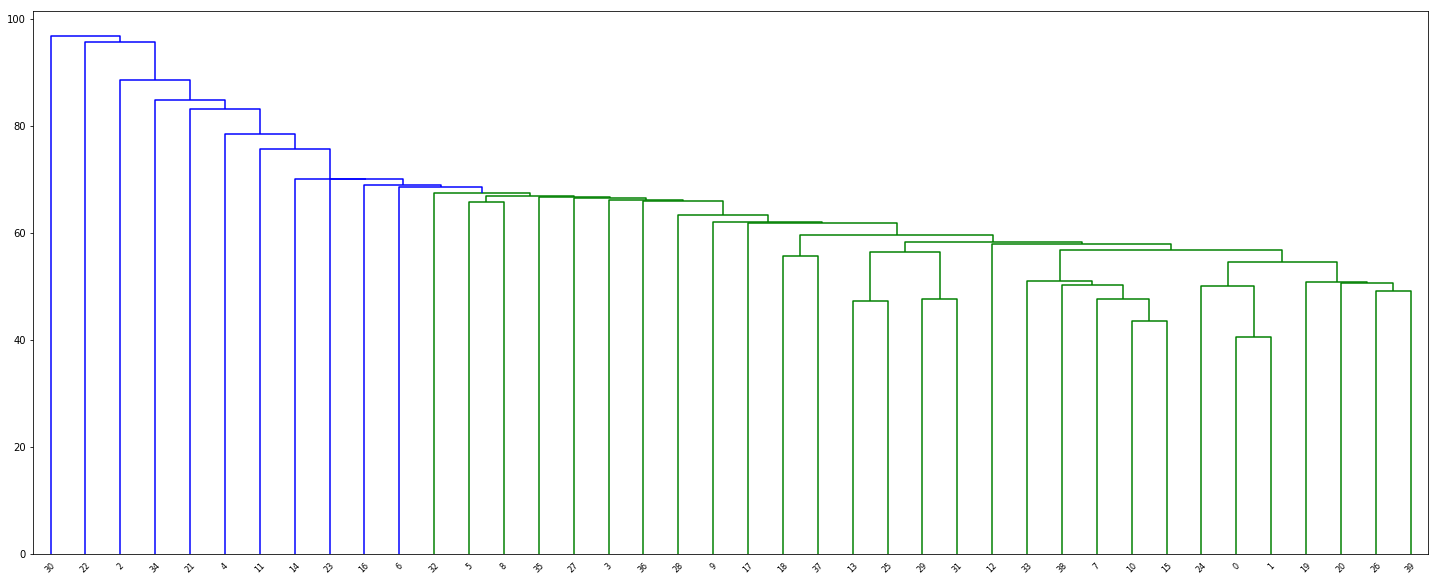

In [38]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [39]:
# ar_models = []
# for series in X:
#     ar = Autoregression(item.loc[:, :"ECoG_ch3"], window_size)
#     ar.fit(10)
#     ar_models.append(ar.coeffecients())

# Тестирование
Пока в разработке

In [1]:
%load_ext autoreload
%aimport testing
from testing import TestFactory

In [41]:
tests = TestFactory()

Получить выборку

Проверить DTW

Elapsed time: 16.97


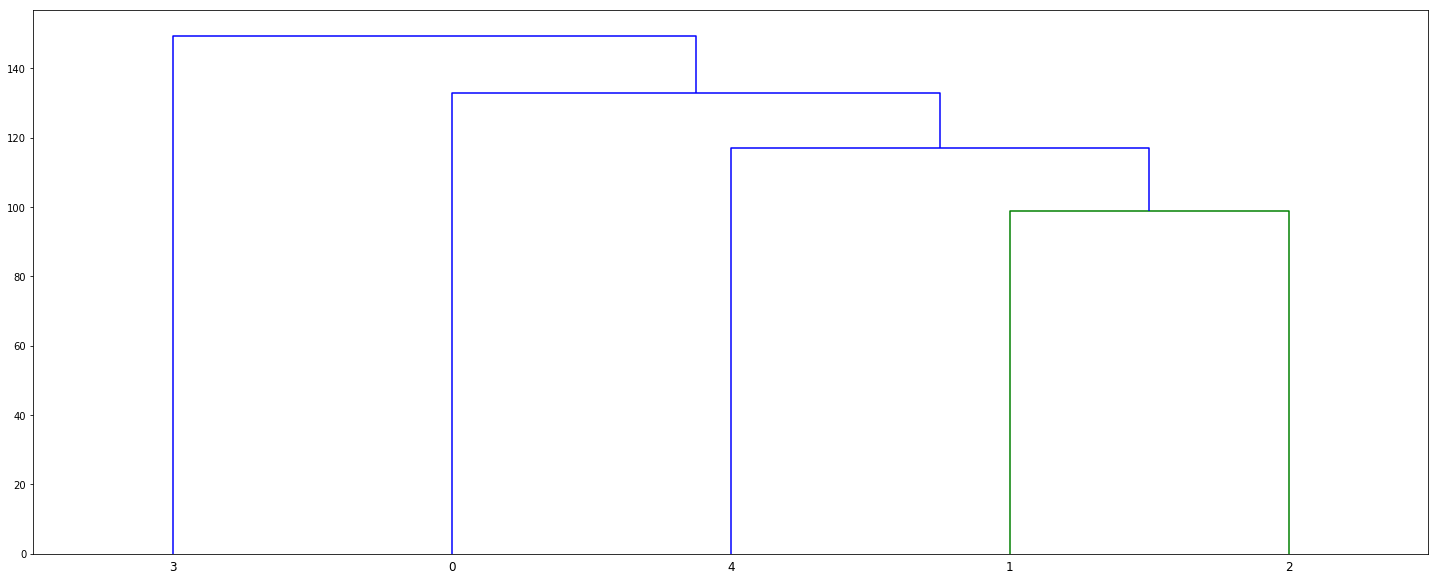

In [42]:
tests.test_dtw(dtw_custom, distance.chebyshev, sample_size=5, visualize=True)

Поле с резузльтатами:
Формат: (dtw_name, distance_name, datetime, elapsed_time)

In [43]:
tests.results

[('dtw',
  'chebyshev',
  datetime.datetime(2018, 10, 15, 22, 54, 25, 268104),
  16.973681211471558)]

Можно сохранять и загружать

In [44]:
tests.dump_result("tmp")

In [45]:
result = TestFactory.load("tmp")

In [46]:
result

[('dtw',
  'chebyshev',
  datetime.datetime(2018, 10, 15, 22, 54, 25, 268104),
  16.973681211471558)]

# Сравнение производительностей

In [15]:
tests = TestFactory()

In [16]:
X = tests.get_n(10)

Elapsed time: 63.08


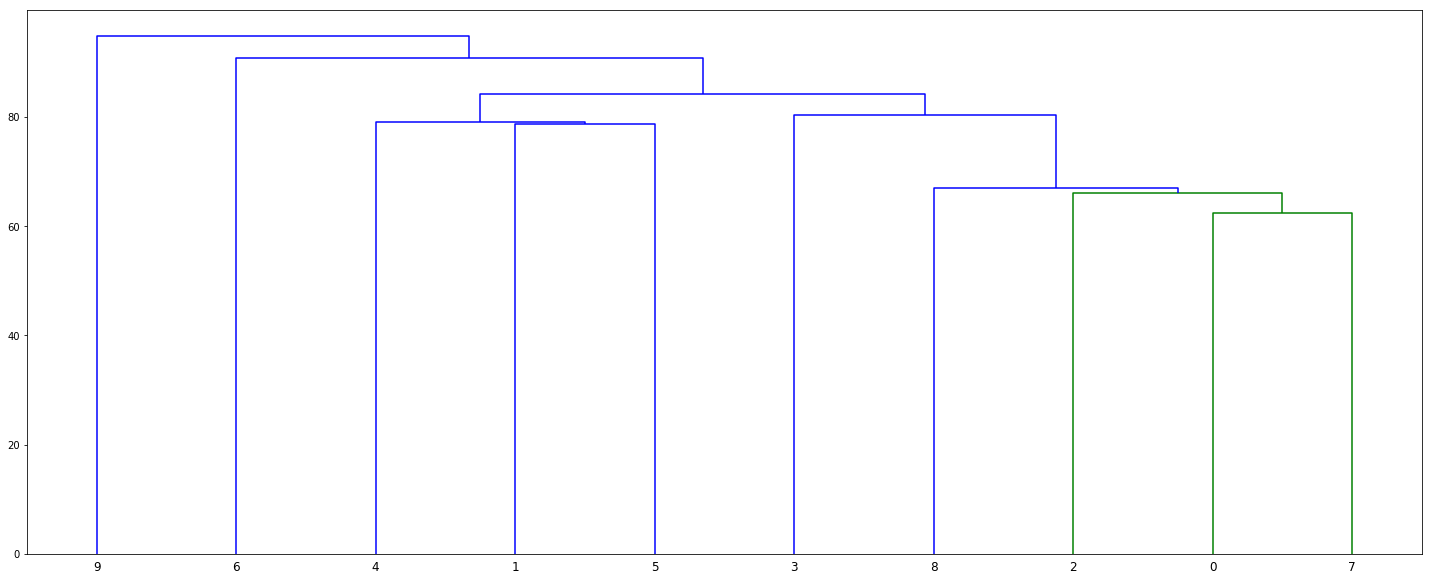

In [18]:
tests.test_dtw(dtw.dtw, distance.chebyshev, visualize=True, X=X)

Elapsed time: 33.25


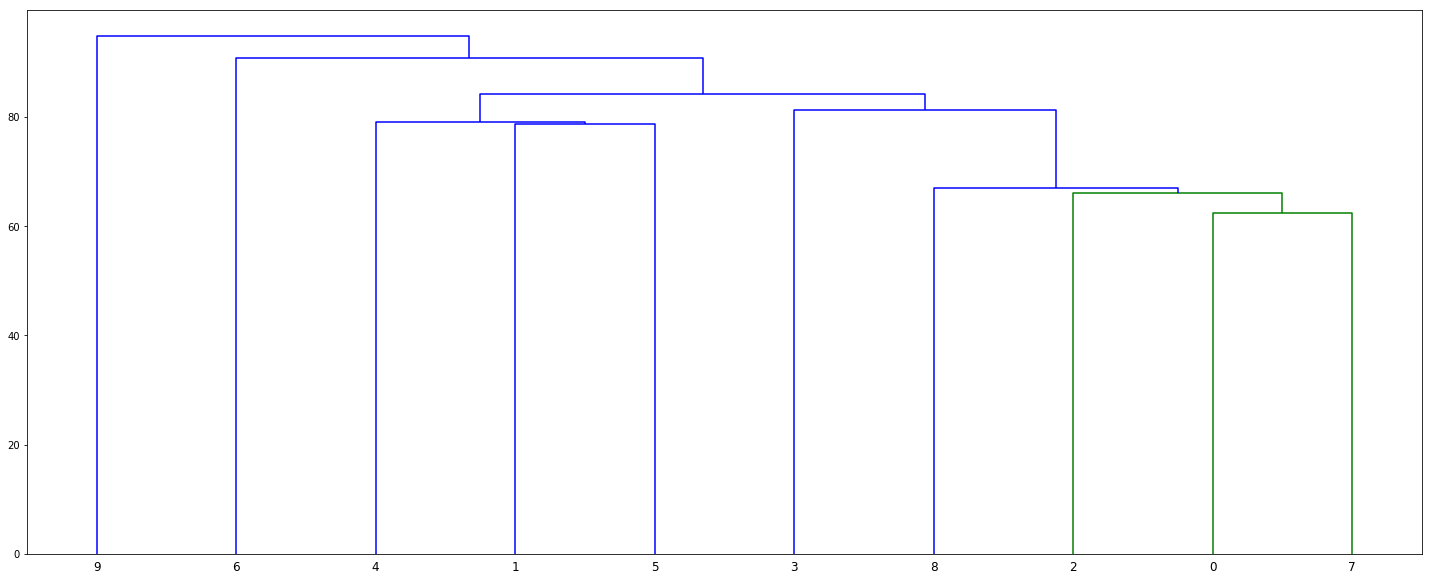

In [19]:
tests.test_dtw(dtw.dtw_ln, distance.chebyshev, visualize=True, X=X)

Elapsed time: 35.08


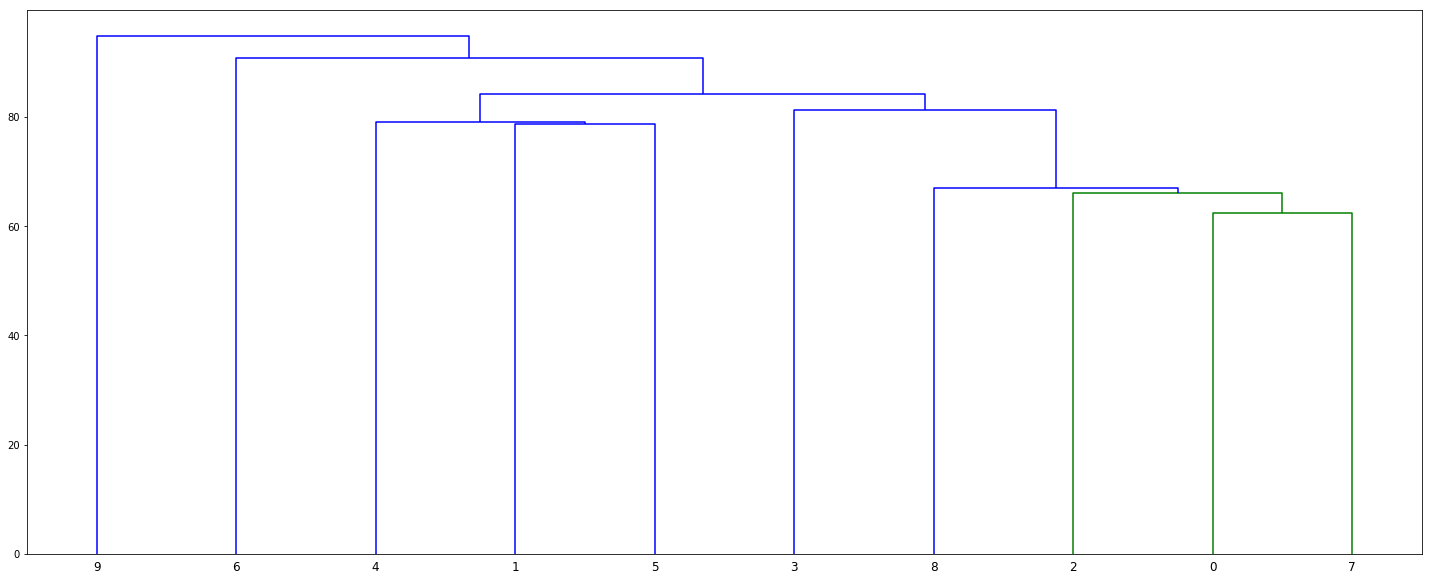

In [20]:
tests.test_dtw(improved_dtw.dtw_improved, distance.chebyshev, visualize=True, X=X)

In [1]:
import time

In [3]:
t = time.time()
time.sleep(3)
print(time.time() - t)

3.0000782012939453


In [ ]:
time.sleep(3)

In [5]:
1.129e+04 / 60 / 60

3.136111111111111